<a href="https://colab.research.google.com/github/jingkloos/Machine-learning/blob/master/AmazonPrimeVideoAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Amazon Prime Video Prediction  aka. OA template

I used supervised prediction model to predict whether a movie perform well on Amazon prime platform. <br>
The matrix I used is cvt --  cumulative view time

## Load Data and import necessary packages

In [1]:
import pandas as pd
import numpy as np
import sklearn.preprocessing as preprocessing
import sklearn as sl
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
pd.set_option('display.float_format',lambda x:'%.3f' % x) 
pd.set_option('display.max_columns',None)  #unlimited so all columns will show
pd.set_option('display.max_rows',None) 
pd.set_option('max_colwidth',100)
mpl.rcParams.update(mpl.rcParamsDefault)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
fileid='1995wXXxa9G8lOV-I0GZgB8YHLcqCEVbB'
url='https://drive.google.com/uc?export=download&id={}'.format(fileid) 
df=pd.read_csv(url,sep=',')
df.head()

,video_id,cvt_per_day,weighted_categorical_position,weighted_horizontal_poition,import_id,release_year,genres,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,awards,mpaa,star_category
0,385504,307127.606,1,3,lionsgate,2013,"Action,Thriller,Drama",69614,15000000,42930462,6.500,112.301,51,other award,PG-13,1.710
1,385504,307.606,1,3,lionsgate,2013,"Action,Thriller,Drama",69614,15000000,42930462,6.500,112.301,51,other award,PG-13,1.710
2,300175,270338.426,1,3,lionsgate,2013,"Comedy,Crime,Thriller",46705,15000000,3301046,6.500,94.983,41,no award,R,3.250
3,361899,256165.867,1,3,other,2012,"Crime,Drama",197596,26000000,37397291,7.300,115.764,58,other award,R,2.647
4,308314,196622.721,3,4,lionsgate,2008,"Thriller,Drama,War,Documentary,Mystery,Action",356339,15000000,15700000,7.600,130.704,94,Oscar,R,1.667


In [ ]:
#second option to load data -- upload from local drive
#from google.colab import files
#uploaded=files.upload()

## Part 1: Data Exploration

### Part 1.1: Exclude erroneous data

In [3]:
#video_id should be unique, check to see if there are duplicates
if df['video_id'].duplicated().sum()==0:
  print('No duplicated index')
else:
  df.drop_duplicates('video_id',inplace=True)
  print('Duplicates were found and dropped')
df.head()

Duplicates were found and dropped


,video_id,cvt_per_day,weighted_categorical_position,weighted_horizontal_poition,import_id,release_year,genres,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,awards,mpaa,star_category
0,385504,307127.606,1,3,lionsgate,2013,"Action,Thriller,Drama",69614,15000000,42930462,6.500,112.301,51,other award,PG-13,1.710
2,300175,270338.426,1,3,lionsgate,2013,"Comedy,Crime,Thriller",46705,15000000,3301046,6.500,94.983,41,no award,R,3.250
3,361899,256165.867,1,3,other,2012,"Crime,Drama",197596,26000000,37397291,7.300,115.764,58,other award,R,2.647
4,308314,196622.721,3,4,lionsgate,2008,"Thriller,Drama,War,Documentary,Mystery,Action",356339,15000000,15700000,7.600,130.704,94,Oscar,R,1.667
5,307201,159841.652,1,3,lionsgate,2013,"Crime,Thriller,Mystery,Documentary",46720,27220000,8551228,6.400,105.546,37,other award,R,3.067


### Part 1.2: Understand numerical features

#### 1.2.1 Overview

In [4]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

# check data info
printmd('**General info of the data:**')
print(df.info())
#video_id is meaningless and release_year should not be treated as numeric data
print('\n')
printmd('**Statistics about numeric data:**')
print(df.drop(['video_id'],axis=1).describe(percentiles=[0.1,0.25,0.5,0.75,0.95]))
print('\n')
printmd('**Percentage of 0 values for each column:**')
print((df==0).sum(axis=0)/df.shape[0])
print('\n')
printmd('**unique values of each column:**')
print(df.nunique())

**General info of the data:**

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4226 entries, 0 to 4226
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   video_id                       4226 non-null   int64  
 1   cvt_per_day                    4226 non-null   float64
 2   weighted_categorical_position  4226 non-null   int64  
 3   weighted_horizontal_poition    4226 non-null   int64  
 4   import_id                      4226 non-null   object 
 5   release_year                   4226 non-null   int64  
 6   genres                         4226 non-null   object 
 7   imdb_votes                     4226 non-null   int64  
 8   budget                         4226 non-null   int64  
 9   boxoffice                      4226 non-null   int64  
 10  imdb_rating                    4226 non-null   float64
 11  duration_in_mins               4226 non-null   float64
 12  metacritic_score               4226 non-null   i

**Statistics about numeric data:**

       cvt_per_day  weighted_categorical_position  \
count     4226.000                       4226.000   
mean      4218.630                          7.783   
std      13036.080                          6.134   
min          2.188                          1.000   
10%        141.985                          3.000   
25%        351.169                          4.000   
50%       1193.500                          6.000   
75%       3356.789                          9.000   
95%      14692.834                         22.000   
max     307127.606                         41.000   

       weighted_horizontal_poition  release_year  imdb_votes        budget  \
count                     4226.000      4226.000    4226.000      4226.000   
mean                        28.104      2001.057    6462.924   2150743.439   
std                         11.864        17.497   31596.007   7176604.483   
min                          1.000      1916.000       0.000         0.000   
10%                       

**Percentage of 0 values for each column:**

video_id                        0.000
cvt_per_day                     0.000
weighted_categorical_position   0.000
weighted_horizontal_poition     0.000
import_id                       0.000
release_year                    0.000
genres                          0.000
imdb_votes                      0.081
budget                          0.581
boxoffice                       0.756
imdb_rating                     0.081
duration_in_mins                0.000
metacritic_score                0.713
awards                          0.000
mpaa                            0.000
star_category                   0.437
dtype: float64




**unique values of each column:**

video_id                         4226
cvt_per_day                      4226
weighted_categorical_position      37
weighted_horizontal_poition        68
import_id                           4
release_year                       97
genres                           1165
imdb_votes                       2282
budget                            253
boxoffice                         410
imdb_rating                        85
duration_in_mins                 4097
metacritic_score                   90
awards                              5
mpaa                                6
star_category                     630
dtype: int64


**Observation:**
1.   There are no null values for all columns 
2.   There are a lot of zeros for columns budget,boxoffice,metacritic_score,star_category




#### 1.2.2 Understand distribution of cvt_per_day

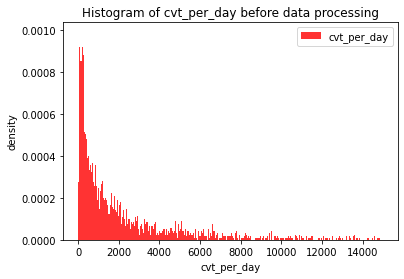

In [5]:
# check label distribution
plt.hist(df['cvt_per_day'],bins=range(0,15000,30),color='red',alpha=0.8,label='cvt_per_day',density=True)
plt.title('Histogram of cvt_per_day before data processing')
plt.legend(loc='upper right')
plt.xlabel('cvt_per_day')
plt.ylabel('density')
plt.grid(False)
plt.show()

#### 1.2.3 Correlation among numerical features

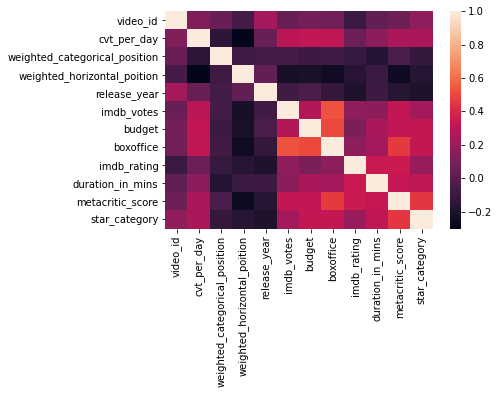

In [6]:
corr_score=df.corr()
sns.heatmap(corr_score)

In [7]:
corr_score

,video_id,cvt_per_day,weighted_categorical_position,weighted_horizontal_poition,release_year,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,star_category
video_id,1.000,0.122,0.050,-0.067,0.231,0.048,0.088,0.072,-0.100,0.024,0.064,0.170
cvt_per_day,0.122,1.000,-0.148,-0.302,0.046,0.298,0.316,0.312,0.059,0.152,0.249,0.247
weighted_categorical_position,0.050,-0.148,1.000,-0.084,-0.069,-0.064,-0.090,-0.074,-0.116,-0.174,-0.044,-0.123
weighted_horizontal_poition,-0.067,-0.302,-0.084,1.000,0.027,-0.221,-0.211,-0.245,-0.162,-0.102,-0.255,-0.168
release_year,0.231,0.046,-0.069,0.027,1.000,-0.083,-0.040,-0.128,-0.199,-0.097,-0.167,-0.198
imdb_votes,0.048,0.298,-0.064,-0.221,-0.083,1.000,0.273,0.531,0.163,0.156,0.322,0.225
budget,0.088,0.316,-0.090,-0.211,-0.040,0.273,1.000,0.505,0.106,0.251,0.315,0.322
boxoffice,0.072,0.312,-0.074,-0.245,-0.128,0.531,0.505,1.000,0.164,0.226,0.465,0.322
imdb_rating,-0.100,0.059,-0.116,-0.162,-0.199,0.163,0.106,0.164,1.000,0.344,0.347,0.192
duration_in_mins,0.024,0.152,-0.174,-0.102,-0.097,0.156,0.251,0.226,0.344,1.000,0.327,0.309


### Part 1.3 Understand categorical features

#### 1.3.1 Distribution of standard categorical features

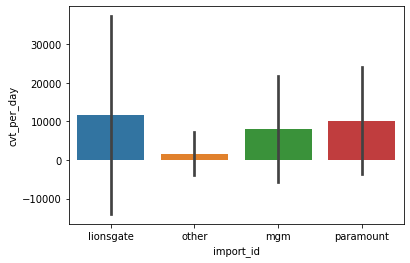

other        2963
lionsgate     677
mgm           445
paramount     141
Name: import_id, dtype: int64


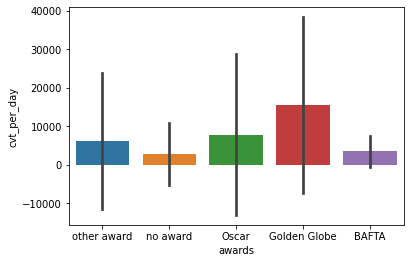

no award        2569
other award     1453
Oscar            141
Golden Globe      44
BAFTA             19
Name: awards, dtype: int64


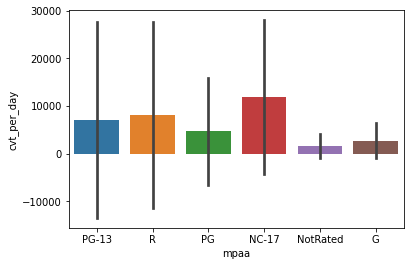

NotRated    2158
R           1158
PG-13        426
PG           353
G            125
NC-17          6
Name: mpaa, dtype: int64


In [8]:
#plots for import_id,awards, mpaa
sns.barplot(x='import_id',y='cvt_per_day',data=df,ci='sd')
plt.show()
print(df['import_id'].value_counts())

sns.barplot(x='awards',y='cvt_per_day',data=df,ci='sd')
plt.show()
print(df['awards'].value_counts())

sns.barplot(x='mpaa',y='cvt_per_day',data=df,ci='sd')
plt.show()
print(df['mpaa'].value_counts())


#### 1.3.2 Distribution of combined categorical feature

Video can belong to more than one genres. In order to explore the impact of each genre, column genre needs to be splited.

                          0      1
Drama                  1677 17.283
Comedy                 1184 12.202
Thriller                879  9.059
Horror                  762  7.853
Action                  739  7.616
Documentary             671  6.915
Romance                 591  6.091
Crime                   437  4.504
Independent             393  4.050
Mystery                 375  3.865
Adventure               363  3.741
Sci-Fi                  363  3.741
Kids & Family           280  2.886
Fantasy                 243  2.504
Music                   171  1.762
Animation               129  1.329
War                     102  1.051
Western                 102  1.051
Sport                    77  0.794
Musicals                 68  0.701
Foreign/International    64  0.660
Anime                    11  0.113
Reality                   9  0.093
Lifestyle                 7  0.072
Adult                     3  0.031
LGBT                      2  0.021
Holiday                   1  0.010


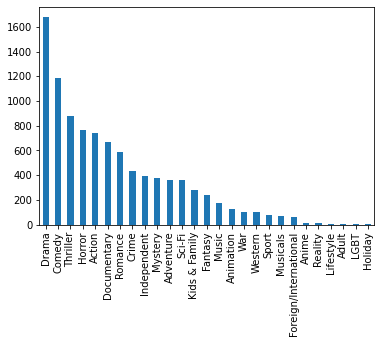

In [9]:
#split genres column and do one-hot encoding
genres=df['genres'].str.get_dummies(sep=',').sum().sort_values(ascending=False)
pc_genres=genres*100/genres.sum()
df_genres=pd.concat([genres,pc_genres],axis=1)
print(df_genres)
genres.plot.bar()


#### 1.3.3 Distribution of release year

Even though release year is numeric type in the dataset, but it is not continuous so it should be treated as categorical feature.
Considering the popularity of a video usually decays over time, the release year should be bucketed based on percentile range.

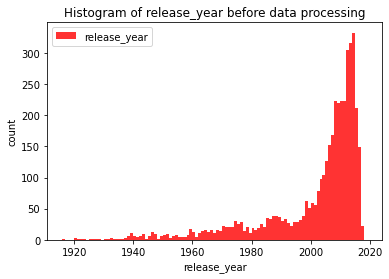

In [10]:
plt.hist(df['release_year'],bins=range(1916,2020,1),color='red',alpha=0.8,label='release_year')
plt.title('Histogram of release_year before data processing')
plt.legend(loc='upper left')
plt.xlabel('release_year')
plt.ylabel('count')
plt.grid(False)
plt.show()

## Part 2:Feature Preprocessing

### Part 2.1 Numeric features

#### 2.1.1 Missing data 

4 out of 10 numerical features have over 25% missing values (shown as 0): budget,boxoffice,metacritic_score,star_category. 2 features have less than 10% missing data: imdb_votes,imdb_rating.

There are only 984 samples that don't have any missing values which means 3242 (4226-981) samples that at least have one missing data.

I will impute missing data in the following process

In [11]:
#missing values
(df==0).sum(axis=1).value_counts()

3    1268
4    1106
0     984
2     470
6     256
5      87
1      55
dtype: int64

In [12]:
#replace 0 with nan
df[['budget','boxoffice','metacritic_score', 'star_category','imdb_votes', 'imdb_rating']]= \
df[['budget','boxoffice','metacritic_score', 'star_category','imdb_votes', 'imdb_rating']].replace(0,np.nan)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4226 entries, 0 to 4226
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   video_id                       4226 non-null   int64  
 1   cvt_per_day                    4226 non-null   float64
 2   weighted_categorical_position  4226 non-null   int64  
 3   weighted_horizontal_poition    4226 non-null   int64  
 4   import_id                      4226 non-null   object 
 5   release_year                   4226 non-null   int64  
 6   genres                         4226 non-null   object 
 7   imdb_votes                     3882 non-null   float64
 8   budget                         1772 non-null   float64
 9   boxoffice                      1032 non-null   float64
 10  imdb_rating                    3882 non-null   float64
 11  duration_in_mins               4226 non-null   float64
 12  metacritic_score               1214 non-null   f

In [13]:
#fill missing data with mean value
newdf=df.copy()
cols=['budget','boxoffice','metacritic_score', 'star_category','imdb_votes', 'imdb_rating']
for col in cols:
  newdf[col]=newdf[col].fillna(newdf[col].mean())
print(newdf.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4226 entries, 0 to 4226
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   video_id                       4226 non-null   int64  
 1   cvt_per_day                    4226 non-null   float64
 2   weighted_categorical_position  4226 non-null   int64  
 3   weighted_horizontal_poition    4226 non-null   int64  
 4   import_id                      4226 non-null   object 
 5   release_year                   4226 non-null   int64  
 6   genres                         4226 non-null   object 
 7   imdb_votes                     4226 non-null   float64
 8   budget                         4226 non-null   float64
 9   boxoffice                      4226 non-null   float64
 10  imdb_rating                    4226 non-null   float64
 11  duration_in_mins               4226 non-null   float64
 12  metacritic_score               4226 non-null   f

#### 2.1.2 Feature scaling

There are two commonly used scale method: normalization (min-max scaler) and standardscaler. The impact of different scalling methods on the model performance is small, so either one will work. I used standardscaler in the following process.

In [14]:
# scale data using standardization
#(x-mean)/std
#only numeric features need to be scaled and label data (cvt_per_day) doesn't need to be scaled
#other scalers: preprocessing.MinMaxScaler(),preprocessing.RobustScaler()
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scl_lst=['weighted_categorical_position', 'weighted_horizontal_poition', 'budget','boxoffice', 
             'imdb_votes','imdb_rating','duration_in_mins', 'metacritic_score','star_category']
scaler.fit(newdf[scl_lst])
newdf[scl_lst]=scaler.transform(newdf[scl_lst])
newdf.head()


,video_id,cvt_per_day,weighted_categorical_position,weighted_horizontal_poition,import_id,release_year,genres,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,awards,mpaa,star_category
0,385504,307127.606,-1.106,-2.116,lionsgate,2013,"Action,Thriller,Drama",1.984,1.470,4.696,0.542,1.079,-0.630,other award,PG-13,0.033
2,300175,270338.426,-1.106,-2.116,lionsgate,2013,"Comedy,Crime,Thriller",1.258,1.470,-1.022,0.542,0.257,-1.997,no award,R,3.434
3,361899,256165.867,-1.106,-2.116,other,2012,"Crime,Drama",6.043,3.108,3.898,1.100,1.243,0.327,other award,R,2.102
4,308314,196622.721,-0.780,-2.032,lionsgate,2008,"Thriller,Drama,War,Documentary,Mystery,Action",11.077,1.470,0.767,1.309,1.952,5.250,Oscar,R,-0.063
5,307201,159841.652,-1.106,-2.116,lionsgate,2013,"Crime,Thriller,Mystery,Documentary",1.258,3.290,-0.265,0.472,0.758,-2.544,other award,R,3.029


### Part 2.2 Categorical features

There are 5 categorical features: import_id, mpaa, awards, genres, and release_year. There are no missing values in them so they can be encoded directly.

'import_id,mpaa,awards' have relatively small subtypes, they can be easily converted to dummies.

'genres' have 27 different sub-types, 6 of them are rarely observed (less than 0.5%) so they will be grouped to others.
'release_year' is binned into 10 buckets based on the year range from 1916 and 2017.

In [15]:
#convert import_id,mpaa,awards to dummy variables
df_import_id=pd.get_dummies(newdf['import_id'])
df_mpaa=pd.get_dummies(newdf['mpaa'])
df_awards=pd.get_dummies(newdf['awards'])
print(df_import_id.info(),df_mpaa.info(),df_awards.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4226 entries, 0 to 4226
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   lionsgate  4226 non-null   uint8
 1   mgm        4226 non-null   uint8
 2   other      4226 non-null   uint8
 3   paramount  4226 non-null   uint8
dtypes: uint8(4)
memory usage: 49.5 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4226 entries, 0 to 4226
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   G         4226 non-null   uint8
 1   NC-17     4226 non-null   uint8
 2   NotRated  4226 non-null   uint8
 3   PG        4226 non-null   uint8
 4   PG-13     4226 non-null   uint8
 5   R         4226 non-null   uint8
dtypes: uint8(6)
memory usage: 57.8 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4226 entries, 0 to 4226
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  ----

In [16]:
#convert genres to dummy variables
df_genres=newdf['genres'].str.get_dummies(sep=',')
df_genres['Misc']=df_genres['Anime']|df_genres['Reality']|df_genres['Lifestyle']|df_genres['Adult']|df_genres['LGBT']|df_genres['Holiday']
df_genres.drop(['Anime', 'Reality','Lifestyle', 'Adult','LGBT','Holiday'],inplace=True,axis=1)
df_genres.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4226 entries, 0 to 4226
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   Action                 4226 non-null   int64
 1   Adventure              4226 non-null   int64
 2   Animation              4226 non-null   int64
 3   Comedy                 4226 non-null   int64
 4   Crime                  4226 non-null   int64
 5   Documentary            4226 non-null   int64
 6   Drama                  4226 non-null   int64
 7   Fantasy                4226 non-null   int64
 8   Foreign/International  4226 non-null   int64
 9   Horror                 4226 non-null   int64
 10  Independent            4226 non-null   int64
 11  Kids & Family          4226 non-null   int64
 12  Music                  4226 non-null   int64
 13  Musicals               4226 non-null   int64
 14  Mystery                4226 non-null   int64
 15  Romance                4226 non-null  

In [17]:
#get release_year range
year_break=newdf['release_year'].quantile([i*0.1 for i in range(1,10)])

In [18]:
#bin release_year and convert it to dummy variable
bin_year=[newdf['release_year'].min()]+list(year_break.values.astype(np.int16))+[newdf['release_year'].max()]
#print(bin_year)
def create_year_label(bin_year):
  i=0
  res=[]
  while i < len(bin_year)-1:
    res.append(str(bin_year[i])+'-'+str(bin_year[i+1]))
    i+=1
  return res

year_range=create_year_label(bin_year)
print(year_range)
#pd.cut is used to convert release_year from int to year_range
new_release_year=pd.cut(newdf['release_year'],bins=bin_year,labels=year_range)
df_year=pd.get_dummies(new_release_year)
df_year.info()

['1916-1974', '1974-1991', '1991-2001', '2001-2006', '2006-2008', '2008-2010', '2010-2012', '2012-2013', '2013-2014', '2014-2017']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4226 entries, 0 to 4226
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   1916-1974  4226 non-null   uint8
 1   1974-1991  4226 non-null   uint8
 2   1991-2001  4226 non-null   uint8
 3   2001-2006  4226 non-null   uint8
 4   2006-2008  4226 non-null   uint8
 5   2008-2010  4226 non-null   uint8
 6   2010-2012  4226 non-null   uint8
 7   2012-2013  4226 non-null   uint8
 8   2013-2014  4226 non-null   uint8
 9   2014-2017  4226 non-null   uint8
dtypes: uint8(10)
memory usage: 74.3 KB


In [19]:
#drop old categorical columns and add new ones
tmp_df=newdf.drop(['import_id', 'mpaa','awards','genres', 'release_year'],axis=1)
model_ready_df=pd.concat([tmp_df,df_import_id,df_awards,df_mpaa,df_genres,df_year],axis=1)
model_ready_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4226 entries, 0 to 4226
Data columns (total 58 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   video_id                       4226 non-null   int64  
 1   cvt_per_day                    4226 non-null   float64
 2   weighted_categorical_position  4226 non-null   float64
 3   weighted_horizontal_poition    4226 non-null   float64
 4   imdb_votes                     4226 non-null   float64
 5   budget                         4226 non-null   float64
 6   boxoffice                      4226 non-null   float64
 7   imdb_rating                    4226 non-null   float64
 8   duration_in_mins               4226 non-null   float64
 9   metacritic_score               4226 non-null   float64
 10  star_category                  4226 non-null   float64
 11  lionsgate                      4226 non-null   uint8  
 12  mgm                            4226 non-null   u

## Part 3: Model Training

### Part 3.1: Split dataset

In [20]:
y=model_ready_df['cvt_per_day']
X=model_ready_df.drop(['video_id','cvt_per_day'],axis=1)

#reserve 25% for testing, random state is seed,to make sure result is the same in every run. random_state can be any number
X_train,X_test,y_train, y_test=train_test_split(X,y,test_size=0.25,random_state=1)
print('training data has '+str(X_train.shape[0]) + ' observation with '+str(X_train.shape[1])+' features')
print('test data has '+str(X_test.shape[0]) + ' observation with '+str(X_test.shape[1])+' features')

training data has 3169 observation with 56 features
test data has 1057 observation with 56 features


### Part 3.2 Model Training and Selection

In [26]:
from sklearn.linear_model import Lasso,Ridge,ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
#use 5-fold cross validation to get accuracy for different models
def get_cv_score(model):
  cv_score=model_selection.cross_val_score(model,X_train,y_train,cv=5,scoring='r2')
  print(cv_score)
  print('CV Mean is '+str(cv_score.mean()))
  print('STD is '+str(cv_score.std()))
#print best score from grid search
def print_grid_search_metrics(gs):
  print('Best score: '+str(gs.best_score_))
  print('Best parameters set:')
  best_params=gs.best_params_
  for param_name in sorted(parameters.keys()):
    print(param_name + ':' + str(best_params[param_name]))


#### 3.2.1 Ridge linear regression (L2 regularization)

In [93]:
from sklearn.linear_model import Ridge
ridge=Ridge(alpha=1).fit(X_train,y_train)
get_cv_score(ridge)


[0.26358443 0.3165767  0.20965524 0.29242421 0.28399714]
CV Mean is 0.2732475435452455
STD is 0.03605016072072478


Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 360 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    5.6s finished


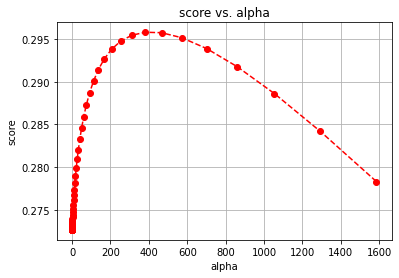

In [94]:
#Tune alpha
alpha=np.logspace (-10, 3.2, num=150)
parameters=dict(alpha=alpha)
grid=GridSearchCV(estimator=ridge,param_grid=parameters,scoring='r2',verbose=1,n_jobs=-1,refit=True)
grid_result=grid.fit(X_train,y_train)
scores=grid_result.cv_results_['mean_test_score']
plt.plot(alpha, scores, color='r', linestyle='dashed', marker='o',markerfacecolor='r', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()


In [95]:
ridge_best=grid.best_estimator_
print_grid_search_metrics(grid)

Best score: 0.2957884168511685
Best parameters set:
alpha:380.0719086471596


#### 3.2.2 Lasso linear regression(L1 regularization)

In [96]:
from sklearn.linear_model import Lasso
lasso=Lasso(alpha=1).fit(X_train,y_train)
get_cv_score(lasso)

[0.26373711 0.31704543 0.20958276 0.29220555 0.2842727 ]
CV Mean is 0.2733687115363487
STD is 0.03617401156972078


Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:  1.5min finished


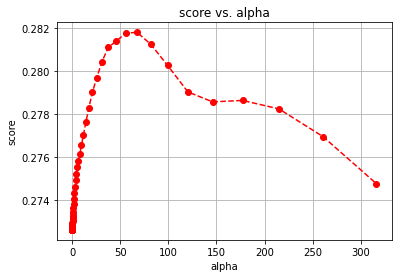

In [97]:
#tune hyperparameter alpha
alpha=np.logspace (-10, 2.5, num=150)
parameters=dict(alpha=alpha)
grid=GridSearchCV(estimator=lasso,param_grid=parameters,scoring='r2',verbose=1,n_jobs=-1,refit=True)
grid_result=grid.fit(X_train,y_train)
scores=grid_result.cv_results_['mean_test_score']
plt.plot(alpha, scores, color='r', linestyle='dashed', marker='o',markerfacecolor='r', markersize=6)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()

In [98]:
lasso_best=grid.best_estimator_
print_grid_search_metrics(grid)

Best score: 0.281808347486216
Best parameters set:
alpha:67.43091617249776


In [99]:
#excluded features
for coef,col in enumerate(X.columns):
  if lasso.coef_[coef] ==0:
    print(f'{col}: {lasso.coef_[coef]}')

mgm: -0.0
BAFTA: -0.0
NC-17: -0.0
PG: 0.0
2006-2008: -0.0


#### 3.2.3 Random Forest

In [100]:
#use default hyperparameter
#default n_estimator=10, max_feature=sqrt which is sqrt(n) features
rf=RandomForestRegressor(random_state=6,max_features='sqrt',n_jobs=-1)
rf.fit(X_train,y_train)
get_cv_score(rf)

[0.56091594 0.58900636 0.38596382 0.51734349 0.59111608]
CV Mean is 0.5288691372699789
STD is 0.07625343994943011


In [101]:
#tune hyperparameter--n_estimator: number of trees and max_depth: depth of each tree
parameters={'n_estimators':[90,91,92,93,94,95,96,97,98,99,100],'max_depth':[15,16,17,18,19,20,21]}
grid=GridSearchCV(estimator=rf,param_grid=parameters,cv=5,refit=True,n_jobs=-1,pre_dispatch='2*n_jobs')
grid_result=grid.fit(X_train,y_train)

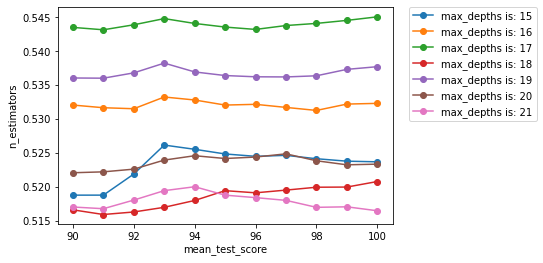

In [113]:
max_depth=parameters['max_depth']
n_estimators=parameters['n_estimators']
scores=grid_result.cv_results_['mean_test_score'].reshape(len(max_depth),len(n_estimators))
plt.figure(1)
plt.subplot(1,1,1)
for i,j in enumerate(max_depth):
  plt.plot(n_estimators,scores[i],'-o',label='max_depths is: '+str(j))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('mean_test_score')
plt.ylabel('n_estimators')
plt.show()

In [103]:
rf_best=grid.best_estimator_
print_grid_search_metrics(grid)

Best score: 0.54508452586169
Best parameters set:
max_depth:17
n_estimators:100


#### 3.2.3 Elastic Net Regression (combo of L1 and L2) (optional)

In [46]:
from sklearn.linear_model import ElasticNet
elastic_net=ElasticNet(alpha=1,l1_ratio=0.5).fit(X_train,y_train)
get_cv_score(elastic_net)

[0.29806187 0.3111505  0.16644269 0.2711252  0.37631474]
CV Mean is 0.2846189991180209
STD is 0.068469648000542


In [48]:
alpha=np.logspace (-10, 3.2, num=15)
l1_ratio=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
parameters=dict(alpha=alpha,l1_ratio=l1_ratio)
grid=GridSearchCV(estimator=elastic_net,param_grid=parameters,scoring='r2',verbose=1,n_jobs=-1,refit=True)
grid_result=grid.fit(X_train,y_train)
scores=grid_result.cv_results_['mean_test_score']


Fitting 5 folds for each of 165 candidates, totalling 825 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 825 out of 825 | elapsed:  1.4min finished


array([ 2.72634254e-01,  2.72634254e-01,  2.72634254e-01,  2.72634254e-01,
        2.72634254e-01,  2.72634254e-01,  2.72634254e-01,  2.72634254e-01,
        2.72634254e-01,  2.72634254e-01,  2.72634254e-01,  2.72634256e-01,
        2.72634256e-01,  2.72634255e-01,  2.72634255e-01,  2.72634255e-01,
        2.72634255e-01,  2.72634255e-01,  2.72634254e-01,  2.72634254e-01,
        2.72634254e-01,  2.72634254e-01,  2.72634271e-01,  2.72634269e-01,
        2.72634268e-01,  2.72634266e-01,  2.72634264e-01,  2.72634263e-01,
        2.72634261e-01,  2.72634259e-01,  2.72634257e-01,  2.72634256e-01,
        2.72634254e-01,  2.72634406e-01,  2.72634391e-01,  2.72634375e-01,
        2.72634360e-01,  2.72634345e-01,  2.72634330e-01,  2.72634315e-01,
        2.72634300e-01,  2.72634284e-01,  2.72634269e-01,  2.72634254e-01,
        2.72635582e-01,  2.72635450e-01,  2.72635317e-01,  2.72635185e-01,
        2.72635052e-01,  2.72634919e-01,  2.72634786e-01,  2.72634654e-01,
        2.72634521e-01,  

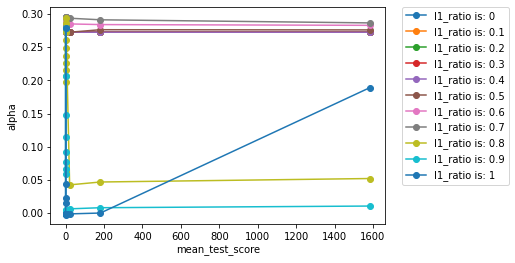

In [53]:
scores=scores.reshape(len(l1_ratio),len(alpha))
plt.figure(1)
plt.subplot(1,1,1)
for i,j in enumerate(l1_ratio):
  plt.plot(alpha,scores[i],'-o',label='l1_ratio is: '+str(j))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('mean_test_score')
plt.ylabel('alpha')
plt.show()

In [54]:
print_grid_search_metrics(grid)

Best score: 0.29581418667153364
Best parameters set:
alpha:0.26826957952797276
l1_ratio:0.4


## Part 4. Model Evaluation

### Part 4.1 Evaluate all models

In [108]:
from sklearn.metrics import  mean_squared_error
def compare_models(model_list):
  score_lst=[]
  mse_lst=[]
  rmse_lst=[]
  for key,item in model_list.items():
    y_pred=item.predict(X_test)
    score=item.score(X_test,y_test)
    mse=mean_squared_error(y_test,y_pred)
    rmse=np.sqrt(mse)
    score_lst.append(score)
    mse_lst.append(mse)
    rmse_lst.append(rmse)
    print('Score of {}: {}'.format(key,score))
    print('Mean square error of {}: {}'.format(key,mse))
    print('Root mean square error of {}: {}'.format(key,rmse))
  return score_lst,mse_lst,rmse_lst

model_list={'lasso':lasso_best,'ridge':ridge_best,'random forest':rf_best}
score_lst,mse_lst,rmse_lst=compare_models(model_list)


Score of lasso: 0.20426242805849348
Mean square error of lasso: 191196276.41312432
Root mean square error of lasso: 13827.374169130027
Score of ridge: 0.19496120416739038
Mean square error of ridge: 193431133.02511603
Root mean square error of ridge: 13907.95215066244
Score of random forest: 0.5376041233556554
Mean square error of random forest: 111102419.89387909
Root mean square error of random forest: 10540.51326520104


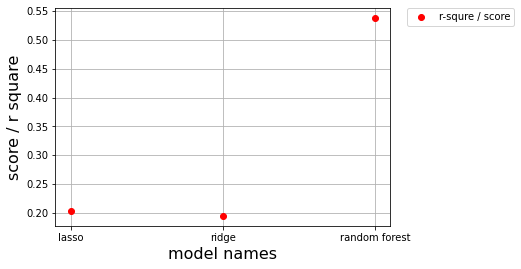

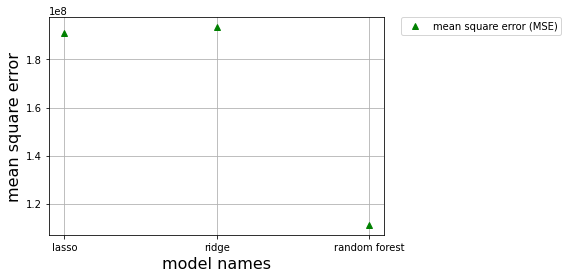

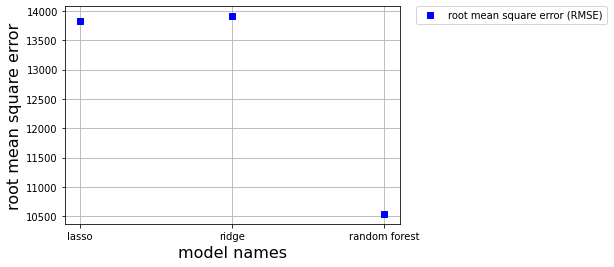

In [119]:
modes=list(model_list.keys())

plt.plot(modes, score_lst, 'ro')
plt.legend(['r-squre / score'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('model names',fontsize =16)
plt.ylabel('score / r square', fontsize =16)
plt.grid(True)
plt.show()


plt.plot(modes, mse_lst, 'g^')
plt.legend(['mean square error (MSE)'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('model names', fontsize =16)
plt.ylabel('mean square error', fontsize =16)
plt.grid(True)
plt.show()

plt.plot(modes, rmse_lst, 'bs')
plt.legend(['root mean square error (RMSE)'],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('model names', fontsize =16)
plt.ylabel('root mean square error', fontsize =16)
plt.grid(True)
plt.show()


**Comparison Result:** Random forest performs much better than the other two linear models

### Part 4.2 Feature importance

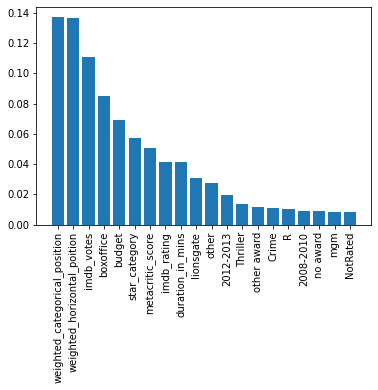

In [120]:
importances = rf_best.feature_importances_
feature_name = X_train.columns.values
#get the index after sorting importances descending
indices = np.argsort(importances)[::-1]
plt.figure(1)
#only show first 20 important feature
plt.bar(feature_name[indices[:20]], importances[indices[:20]])
plt.xticks(rotation=90)
plt.show()